In [8]:
import xarray as xr
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import rioxarray

In [21]:
da = xr.DataArray(
[[1,2,3],
       [4,5,6]],
dims=("x", "y"),
coords={"x": [0.5,1.5], "y": [2.5,1.5,0.5]},
)

d = {'geometry': [Polygon([(0, 0), (0,2), (2, 2), (2, 0)]),Polygon([(2,0),(2,2),(3,2),(3,0)])]}
gdf = gpd.GeoDataFrame(d)

zonal_stats(
    vectors=gdf,
    raster=da.values,
    affine=da.rio.transform(),
    stats=["mean","count"],
    all_touched=True,
)


/Users/cwaigl/miniconda3/envs/python38_geo/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'mean': 4.5, 'count': 2}, {'mean': 6.0, 'count': 1}]

(0.0, 4.0)

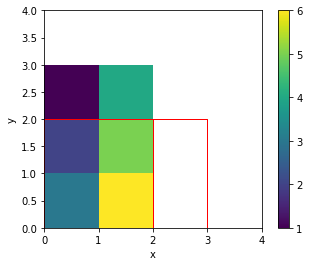

In [22]:
#plotting to illustrate the data
fig, ax = plt.subplots()
da.plot(ax=ax,x="x",y="y")
gdf.boundary.plot(ax=ax, color='r', lw=1)
ax.set_xlim(0,4)
ax.set_ylim(0,4)

In [11]:
da.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, -1.0, 3.0)